In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/DDAMNoErrors/part-00000-ff5f5344-ef1f-4e96-bf77-3feccf9df5f7-c000.csv
/kaggle/input/ddampandas/GloDDAM_Pandas.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=45dd431f36cde9ea0ce3de904afc378000a2aa3286ba58ee70576843f723e89c
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local[*]").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 17:15:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession

In [5]:
from pyspark.sql.types import Row

# Importing required libraries for VIF Calculation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import coalesce
import pyspark.ml.feature as MF
from pyspark.ml.feature import MinMaxScaler

In [6]:
path =  '/kaggle/input/DDAMNoErrors/part-00000-ff5f5344-ef1f-4e96-bf77-3feccf9df5f7-c000.csv'
df = spark.read.option("escape","\"").csv(path, header='true', inferSchema='true')

In [7]:
df.show()

+-------+--------------------+----------+-------------------+-----+----+-------+----+------+------+---+------------+----------+------+
|    _c0|                time|  latitude|          longitude|depth| mag|magType| nst|   gap|   rms|net|        type|depthError|magNst|
+-------+--------------------+----------+-------------------+-----+----+-------+----+------+------+---+------------+----------+------+
|1735390|1979-12-26 20:06:...|    34.166|-119.10016670000002|13.65|-1.0|    mun|26.0|  90.0|  0.38| ci|  earthquake|      1.03|  null|
|  99575|1979-07-23 19:11:...|35.0431667|          -117.6915| 0.02|-1.0|    mun|22.0| 112.0|  0.19| ci|quarry blast|      1.46|  null|
|2420734|2015-07-23 02:56:...|   36.6122|          -116.2146|  7.2|-1.0|     ml| 3.0|177.62|0.0139| nn|  earthquake|       6.8|   2.0|
|2420737|2015-07-23 02:49:...|   36.6153|          -116.2297|  7.4|-1.0|     ml| 3.0|172.57|0.0471| nn|  earthquake|       6.9|   2.0|
|2528591|2012-05-03 12:33:...|   36.6518|          -116

In [8]:
#2570408
df.count()

2570408

In [9]:
#change time feature so as to be able to use it in the correlation 
#timestamp function converts to seconds starting from 1/1/1970
import pyspark.sql.functions as F
change = F.unix_timestamp(df.time,"MM-dd-yyyy HH:mm:ss")
df = df.withColumn("time_unix", change)
df = df.drop('time')

In [10]:
df.columns

['_c0',
 'latitude',
 'longitude',
 'depth',
 'mag',
 'magType',
 'nst',
 'gap',
 'rms',
 'net',
 'type',
 'depthError',
 'magNst',
 'time_unix']

In [11]:
df.select('time_unix').show()

+----------+
| time_unix|
+----------+
| 315086786|
| 301605097|
|1437620178|
|1437619768|
|1336048398|
|1266657380|
|1244189743|
|1246976069|
|1466957728|
|1381038020|
|1347813778|
|1470927501|
|1355467621|
|1444199277|
|1433908641|
|1449313133|
|1367237603|
|1332319806|
|1494849112|
|1371571137|
+----------+
only showing top 20 rows



In [12]:
perc = df.select(*(F.round(((F.sum(F.col(c).isNull().cast("int")))/F.count(F.lit(1))*100),2).alias(c) for c in df.columns))
perc.show()

+---+--------+---------+-----+---+-------+-----+-----+---+---+----+----------+------+---------+
|_c0|latitude|longitude|depth|mag|magType|  nst|  gap|rms|net|type|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-------+-----+-----+---+---+----+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|    0.0|22.83|18.87|0.0|0.0| 0.0|       0.0| 20.92|      0.0|
+---+--------+---------+-----+---+-------+-----+-----+---+---+----+----------+------+---------+



The idea is to temporarly make a dataset without nans so as to make the correlation matrix

In [13]:
df_copy = df.alias('df_copy')#make copy of df for safeness

nans = ['nst', 'gap','magNst']
df_all = df.na.drop(subset = nans)
df_all.count()

1895280

In [14]:
df_all.show()

+-------+--------+---------+-----+----+-------+----+------+------+---+----------+----------+------+----------+
|    _c0|latitude|longitude|depth| mag|magType| nst|   gap|   rms|net|      type|depthError|magNst| time_unix|
+-------+--------+---------+-----+----+-------+----+------+------+---+----------+----------+------+----------+
|2420734| 36.6122|-116.2146|  7.2|-1.0|     ml| 3.0|177.62|0.0139| nn|earthquake|       6.8|   2.0|1437620178|
|2420737| 36.6153|-116.2297|  7.4|-1.0|     ml| 3.0|172.57|0.0471| nn|earthquake|       6.9|   2.0|1437619768|
|2528591| 36.6518|-116.2809|  4.3|-1.0|     ml| 5.0|215.62|0.1261| nn|earthquake|       6.5|   2.0|1336048398|
|1522836| 36.7017|-116.3014| 11.0|-1.0|     ml|12.0|176.73|0.0858| nn|earthquake|       1.6|   4.0|1266657380|
|2826639| 36.7074|-116.3186|  8.2|-1.0|     ml| 6.0|212.19|0.0425| nn|earthquake|       2.4|   1.0|1244189743|
| 738177| 36.7109|-116.3006|  9.5|-1.0|     ml| 5.0|199.96|0.0095| nn|earthquake|       2.4|   2.0|1246976069|
|

In [15]:
df_all.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- gap: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- net: string (nullable = true)
 |-- type: string (nullable = true)
 |-- depthError: double (nullable = true)
 |-- magNst: double (nullable = true)
 |-- time_unix: long (nullable = true)



# Correlation matrix

In [16]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns = ['latitude',
 'longitude',
 'depth',
 'mag',
 'nst',
 'gap',
 'rms',
 'depthError',
 'magNst',
          'time_unix']

In [17]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols= columns, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(df_all).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, -0.4096709261387662, -0.4919170088759089, -0.46698086217066914, -0.16378532232012238, 0.02140835149886602, -0.35552579938517326, -0.1752971740783782, -0.09561072480400393, -0.06798581965868307], [-0.4096709261387662, 1.0, 0.3606531789080033, 0.48411720470011155, 0.20259483055364846, 0.015465694828206365, 0.4273839439975147, 0.1821094052885465, 0.03634311984165595, 0.07911347118623269], [-0.4919170088759089, 0.3606531789080033, 1.0, 0.3666385685005032, 0.1726221615600422, 0.0216905003393382, 0.3305956480554015, 0.13387794568321024, 0.03518816503136193, 0.06637817980390201], [-0.46698086217066914, 0.48411720470011155, 0.3666385685005032, 1.0, 0.3803210079613808, -0.11017581900080922, 0.4264998929228177, 0.16102790115446214, 0.3351211332947558, -0.1816651317089257], [-0.16378532232012238, 0.20259483055364846, 0.1726221615600422, 0.3803210079613808, 1.0, -0.3472979745477538, 0.17170979575893738, -0.06310879308271056, 0.5303030114387343, 0.19703087958446966], [0.02140835149886602, 0.

In [18]:
#df_corr = spark.createDataFrame(corrmatrix,columns)
#df_corr.show()

In [19]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [20]:
"""fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(columns)), labels=columns)
ax.set_yticks(np.arange(len(columns)), labels=columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")



for i in range(len(corrmatrix)):  #[ [10,4],[2,33],[4,53] ]
    for e in range(len(corrmatrix[i])):
        text = ax.text(e,i,np.round(corrmatrix[i][e], 3),
                        color="r")

ax.set_title("prova")
fig.tight_layout()
plt.figure(figsize=(28,16))
plt.show()"""

'fig, ax = plt.subplots()\n\nax.set_xticks(np.arange(len(columns)), labels=columns)\nax.set_yticks(np.arange(len(columns)), labels=columns)\n\nplt.setp(ax.get_xticklabels(), rotation=45, ha="right",\n         rotation_mode="anchor")\n\n\n\nfor i in range(len(corrmatrix)):  #[ [10,4],[2,33],[4,53] ]\n    for e in range(len(corrmatrix[i])):\n        text = ax.text(e,i,np.round(corrmatrix[i][e], 3),\n                        color="r")\n\nax.set_title("prova")\nfig.tight_layout()\nplt.figure(figsize=(28,16))\nplt.show()'

<AxesSubplot:>

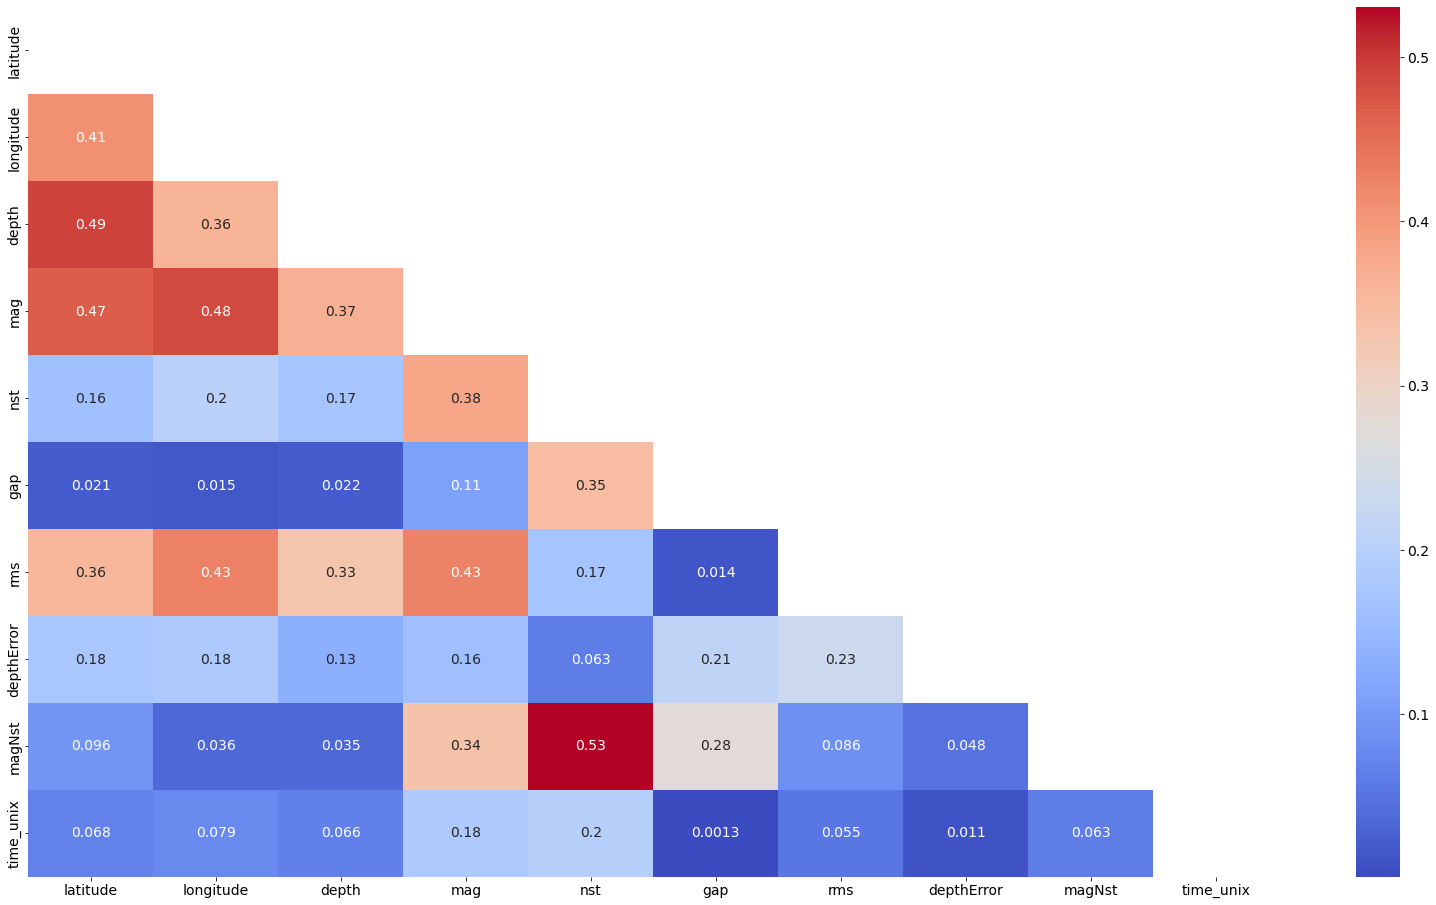

In [21]:
x_axis_labels = columns # labels for x-axis
y_axis_labels = columns # labels for y-axis



import seaborn as sns

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(28,16))
corr=corrmatrix
mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(np.absolute(corr),annot=True,cmap="coolwarm",mask=mask,xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [22]:
df = df.drop('net') #unuseful column

In [23]:
perc = df.select(*(F.round(((F.sum(F.col(c).isNull().cast("int")))/F.count(F.lit(1))*100),2).alias(c) for c in df.columns))
perc.show()

+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|_c0|latitude|longitude|depth|mag|magType|  nst|  gap|rms|type|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|    0.0|22.83|18.87|0.0| 0.0|       0.0| 20.92|      0.0|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+



In [24]:
df.count()

2570408

# Clean categorical values

In [25]:
df.columns

['_c0',
 'latitude',
 'longitude',
 'depth',
 'mag',
 'magType',
 'nst',
 'gap',
 'rms',
 'type',
 'depthError',
 'magNst',
 'time_unix']

In [26]:
df_cat = df.select('_c0', 'magType', 'type')

In [27]:
df_cat.select('magType').distinct().show(50)
#mb_lg & mb_Lg
#Unknown
#ml & Ml
#md & Md
#mb & Mb
#mw & Mw

+-------+
|magType|
+-------+
|  ms_20|
|     Md|
|  mb_lg|
|    mlg|
|      m|
|     ms|
|     mc|
|    mlr|
|Unknown|
|    mww|
|  mb_Lg|
|    mwr|
|     ml|
|   mblg|
|    mwb|
|     ma|
|     no|
|     Ml|
|     Mb|
|     mh|
|     mb|
|    mdl|
|     md|
|    mwc|
|    mun|
|      H|
|     mw|
|     Mw|
|     me|
+-------+



In [28]:
df_cat = df_cat.select('_c0', 'type',F.lower("magType").alias('magType'))

In [29]:
df_cat.select('magType').distinct().show(50)

+-------+
|magType|
+-------+
|  ms_20|
|  mb_lg|
|    mlg|
|unknown|
|      m|
|     ms|
|     mc|
|    mlr|
|      h|
|    mww|
|    mwr|
|     ml|
|   mblg|
|    mwb|
|     ma|
|     no|
|     mh|
|     mb|
|    mdl|
|     md|
|    mwc|
|    mun|
|     mw|
|     me|
+-------+



In [30]:
temp = df_cat.groupBy("magType").count()
temp.show(50,truncate=False)

+-------+-------+
|magType|count  |
+-------+-------+
|ms_20  |4      |
|mb_lg  |1830   |
|mlg    |190    |
|unknown|1      |
|m      |546    |
|ms     |364    |
|mc     |194703 |
|mlr    |4      |
|h      |13     |
|mww    |3725   |
|mwr    |4524   |
|ml     |995656 |
|mblg   |126    |
|mwb    |882    |
|ma     |3705   |
|no     |3      |
|mh     |102847 |
|mb     |176867 |
|mdl    |20166  |
|md     |1055278|
|mwc    |4837   |
|mun    |98     |
|mw     |4038   |
|me     |1      |
+-------+-------+



In [31]:
temp_filt = temp.filter((temp['count'] <= 10000))
temp_filt.show()

+-------+-----+
|magType|count|
+-------+-----+
|  ms_20|    4|
|  mb_lg| 1830|
|    mlg|  190|
|unknown|    1|
|      m|  546|
|     ms|  364|
|    mlr|    4|
|      h|   13|
|    mww| 3725|
|    mwr| 4524|
|   mblg|  126|
|    mwb|  882|
|     ma| 3705|
|     no|    3|
|    mwc| 4837|
|    mun|   98|
|     mw| 4038|
|     me|    1|
+-------+-----+



In [32]:
list_changee = [row_iterator['magType'] for row_iterator in temp_filt.collect()]

In [33]:
list_changee

['ms_20',
 'mb_lg',
 'mlg',
 'unknown',
 'm',
 'ms',
 'mlr',
 'h',
 'mww',
 'mwr',
 'mblg',
 'mwb',
 'ma',
 'no',
 'mwc',
 'mun',
 'mw',
 'me']

In [34]:
df_cat = df_cat.withColumn("magType", F.when(df_cat.magType.isin(list_changee), 'other' ).otherwise(df_cat.magType))
df_cat.show()

+-------+------------+-------+
|    _c0|        type|magType|
+-------+------------+-------+
|1735390|  earthquake|  other|
|  99575|quarry blast|  other|
|2420734|  earthquake|     ml|
|2420737|  earthquake|     ml|
|2528591|  earthquake|     ml|
|1522836|  earthquake|     ml|
|2826639|  earthquake|     ml|
| 738177|  earthquake|     ml|
|2004774|  earthquake|     ml|
|2702952|  earthquake|     ml|
| 209500|  earthquake|     ml|
|2338720|  earthquake|     ml|
|3054998|  earthquake|     ml|
| 477740|  earthquake|     ml|
| 224601|  earthquake|     ml|
| 265463|  earthquake|     ml|
|1789319|  earthquake|     ml|
| 836016|  earthquake|     ml|
| 364376|  earthquake|     ml|
|1539731|  earthquake|     ml|
+-------+------------+-------+
only showing top 20 rows



In [35]:
df_cat.groupBy("magType").count().show()  #:))))))

+-------+-------+
|magType|  count|
+-------+-------+
|     mc| 194703|
|  other|  24891|
|     ml| 995656|
|     mh| 102847|
|     mb| 176867|
|    mdl|  20166|
|     md|1055278|
+-------+-------+



In [36]:
df_cat = df_cat.withColumn("type", F.when(df_cat.type != 'earthquake', 'other' ).otherwise(df_cat.type))
df_cat.show()

+-------+----------+-------+
|    _c0|      type|magType|
+-------+----------+-------+
|1735390|earthquake|  other|
|  99575|     other|  other|
|2420734|earthquake|     ml|
|2420737|earthquake|     ml|
|2528591|earthquake|     ml|
|1522836|earthquake|     ml|
|2826639|earthquake|     ml|
| 738177|earthquake|     ml|
|2004774|earthquake|     ml|
|2702952|earthquake|     ml|
| 209500|earthquake|     ml|
|2338720|earthquake|     ml|
|3054998|earthquake|     ml|
| 477740|earthquake|     ml|
| 224601|earthquake|     ml|
| 265463|earthquake|     ml|
|1789319|earthquake|     ml|
| 836016|earthquake|     ml|
| 364376|earthquake|     ml|
|1539731|earthquake|     ml|
+-------+----------+-------+
only showing top 20 rows



In [37]:
df_cat.groupBy("type").count().show()  

+----------+-------+
|      type|  count|
+----------+-------+
|earthquake|2509558|
|     other|  60850|
+----------+-------+



In [38]:
df_cat.show(5)

+-------+----------+-------+
|    _c0|      type|magType|
+-------+----------+-------+
|1735390|earthquake|  other|
|  99575|     other|  other|
|2420734|earthquake|     ml|
|2420737|earthquake|     ml|
|2528591|earthquake|     ml|
+-------+----------+-------+
only showing top 5 rows



# To do
1. OHE
2. Decide which column's missing values to predict
3. Blind Test
4. Division TR e TS
5. Outliers -> only remove from TR
6. Standardization + join for categorical 
7. Regression AIC Missing Values

# 1: OHE

In [39]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='type', outputCol='type_numeric')
indexer_fitted_type= indexer.fit(df_cat)
df_cat_indexed = indexer_fitted_type.transform(df_cat)
df_cat_indexed.show()

+-------+----------+-------+------------+
|    _c0|      type|magType|type_numeric|
+-------+----------+-------+------------+
|1735390|earthquake|  other|         0.0|
|  99575|     other|  other|         1.0|
|2420734|earthquake|     ml|         0.0|
|2420737|earthquake|     ml|         0.0|
|2528591|earthquake|     ml|         0.0|
|1522836|earthquake|     ml|         0.0|
|2826639|earthquake|     ml|         0.0|
| 738177|earthquake|     ml|         0.0|
|2004774|earthquake|     ml|         0.0|
|2702952|earthquake|     ml|         0.0|
| 209500|earthquake|     ml|         0.0|
|2338720|earthquake|     ml|         0.0|
|3054998|earthquake|     ml|         0.0|
| 477740|earthquake|     ml|         0.0|
| 224601|earthquake|     ml|         0.0|
| 265463|earthquake|     ml|         0.0|
|1789319|earthquake|     ml|         0.0|
| 836016|earthquake|     ml|         0.0|
| 364376|earthquake|     ml|         0.0|
|1539731|earthquake|     ml|         0.0|
+-------+----------+-------+------

In [40]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='magType', outputCol='magType_numeric')
indexer_fitted_magType = indexer.fit(df_cat_indexed)
df_cat_final = indexer_fitted_magType.transform(df_cat_indexed)
df_cat_final.show()

+-------+----------+-------+------------+---------------+
|    _c0|      type|magType|type_numeric|magType_numeric|
+-------+----------+-------+------------+---------------+
|1735390|earthquake|  other|         0.0|            5.0|
|  99575|     other|  other|         1.0|            5.0|
|2420734|earthquake|     ml|         0.0|            1.0|
|2420737|earthquake|     ml|         0.0|            1.0|
|2528591|earthquake|     ml|         0.0|            1.0|
|1522836|earthquake|     ml|         0.0|            1.0|
|2826639|earthquake|     ml|         0.0|            1.0|
| 738177|earthquake|     ml|         0.0|            1.0|
|2004774|earthquake|     ml|         0.0|            1.0|
|2702952|earthquake|     ml|         0.0|            1.0|
| 209500|earthquake|     ml|         0.0|            1.0|
|2338720|earthquake|     ml|         0.0|            1.0|
|3054998|earthquake|     ml|         0.0|            1.0|
| 477740|earthquake|     ml|         0.0|            1.0|
| 224601|earth

In [41]:
indexer_fitted_type.labels

['earthquake', 'other']

In [42]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors

encoder = OneHotEncoder(inputCols = ["type_numeric", "magType_numeric"],outputCols = ["OHE_type", "OHE_magType"])

df_onehot = encoder.fit(df_cat_final).transform(df_cat_final)
df_onehot.show()

+-------+----------+-------+------------+---------------+-------------+-------------+
|    _c0|      type|magType|type_numeric|magType_numeric|     OHE_type|  OHE_magType|
+-------+----------+-------+------------+---------------+-------------+-------------+
|1735390|earthquake|  other|         0.0|            5.0|(1,[0],[1.0])|(6,[5],[1.0])|
|  99575|     other|  other|         1.0|            5.0|    (1,[],[])|(6,[5],[1.0])|
|2420734|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
|2420737|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
|2528591|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
|1522836|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
|2826639|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
| 738177|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|
|2004774|earthquake|     ml|         0.0|            1

In [43]:
from pyspark.ml.functions import vector_to_array
df_col_onehot = df_onehot.select('*', vector_to_array("OHE_type").alias('col_OHE_type'), \
                                                                         
vector_to_array("OHE_magType").alias('col_OHE_magType')  )
df_col_onehot.show()

+-------+----------+-------+------------+---------------+-------------+-------------+------------+--------------------+
|    _c0|      type|magType|type_numeric|magType_numeric|     OHE_type|  OHE_magType|col_OHE_type|     col_OHE_magType|
+-------+----------+-------+------------+---------------+-------------+-------------+------------+--------------------+
|1735390|earthquake|  other|         0.0|            5.0|(1,[0],[1.0])|(6,[5],[1.0])|       [1.0]|[0.0, 0.0, 0.0, 0...|
|  99575|     other|  other|         1.0|            5.0|    (1,[],[])|(6,[5],[1.0])|       [0.0]|[0.0, 0.0, 0.0, 0...|
|2420734|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|       [1.0]|[0.0, 1.0, 0.0, 0...|
|2420737|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|       [1.0]|[0.0, 1.0, 0.0, 0...|
|2528591|earthquake|     ml|         0.0|            1.0|(1,[0],[1.0])|(6,[1],[1.0])|       [1.0]|[0.0, 1.0, 0.0, 0...|
|1522836|earthquake|     ml|         0.0

In [44]:
num_categories_type = len(df_col_onehot.first()['col_OHE_type'])
num_categories_magType = len(df_col_onehot.first()['col_OHE_magType']) 

cols_expanded_type = [(F.col('col_OHE_type')[i].alias("type_"+f'{indexer_fitted_type.labels[i]}')) for i in range(num_categories_type)]
cols_expanded_magType = [(F.col('col_OHE_magType')[i].alias("magType_"+f'{indexer_fitted_magType.labels[i]}')) for i in range(num_categories_magType)]

df_cols_onehot = df_col_onehot.select('_c0', *cols_expanded_type, *cols_expanded_magType)
df_cols_onehot.show()

+-------+---------------+----------+----------+----------+----------+----------+-------------+
|    _c0|type_earthquake|magType_md|magType_ml|magType_mc|magType_mb|magType_mh|magType_other|
+-------+---------------+----------+----------+----------+----------+----------+-------------+
|1735390|            1.0|       0.0|       0.0|       0.0|       0.0|       0.0|          1.0|
|  99575|            0.0|       0.0|       0.0|       0.0|       0.0|       0.0|          1.0|
|2420734|            1.0|       0.0|       1.0|       0.0|       0.0|       0.0|          0.0|
|2420737|            1.0|       0.0|       1.0|       0.0|       0.0|       0.0|          0.0|
|2528591|            1.0|       0.0|       1.0|       0.0|       0.0|       0.0|          0.0|
|1522836|            1.0|       0.0|       1.0|       0.0|       0.0|       0.0|          0.0|
|2826639|            1.0|       0.0|       1.0|       0.0|       0.0|       0.0|          0.0|
| 738177|            1.0|       0.0|       1.0|   

In [45]:
perc.show()

+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|_c0|latitude|longitude|depth|mag|magType|  nst|  gap|rms|type|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|    0.0|22.83|18.87|0.0| 0.0|       0.0| 20.92|      0.0|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+



# CREATE MULTIPLE FUNCTIONS TO AUTOMATE WORK

In [46]:
df = df.drop('type', 'magType')

# 2: Decide which column's missing values to predict

In [47]:
def feature_selection_wrt_out(df, cols_to_keep, nans_to_fill, TS):
    if len(nans_to_fill) > 0:  #only run if list is not empty (otherwise it means we are running the last iteration of notebook)
        # First fill Nans with mean 
        imputer = MF.Imputer(strategy='mean', inputCols= nans_to_fill, outputCols= nans_to_fill) #rewrite
        model = imputer.fit(df)
        model = model.transform(df)
        print("model: ")
        model.show(5)

        cols = [col for col in model.columns if col not in cols_to_keep]
    
        df_missing = model.drop(*cols)  ### drop not highly correlated features
        
    else:
        cols = [col for col in df.columns if col not in cols_to_keep]
    
        df_missing = df.drop(*cols)  ### drop not highly correlated features
        
    TS = TS.drop(*cols)
        
    
    return df_missing, TS

## 3 & 4 : Blind TS + Division TR and TS (not blind)

In [48]:
def TR_TS_division(df):
    ############################# proportions #######################################
    # Let's create a unique TS for all the 3 regression tasks; this will also improve the classification Task
    missing = df.filter(df['gap'].isNull() | df['magNst'].isNull() | df['nst'].isNull())  #put all nans temporarly into TR
    temp = df.na.drop()

    print("missing count: ", missing.count())
    print("temp count: ", temp.count())
    print("df count: ", df.count())
    
    amount_of_TS = df.count()/100*20
    print("amount of TS: ", amount_of_TS)
    # I must select this  respective amount on temp, by means of the following equation
    # --> dfcount*20/100 = temp*x/100
    # x = ((dfcount*20/100) / temp)*100
    
    # ((df.count()*20/100) / temp.count())*100
    perc_TS = ((df.count()*20/100) / temp.count())
    print("perc TS: ", perc_TS)


    ############################# splits #######################################
    TR_TS_temp = temp.randomSplit([1 - perc_TS, 0.0, perc_TS])

    # union TR and missing
    TR = TR_TS_temp[0].union(missing)
    TS = TR_TS_temp[2]
    
    return TR, TS

In [49]:
def TR_blindTS_division(TR, col_with_nans):
    blind_TS = TR.filter(TR[col_with_nans].isNull())  #blind_TS division
    df_TR = TR.na.drop(subset = [col_with_nans])
    
    return blind_TS, df_TR

# 5: Outliers

In [50]:
def find_outliers(df):



   # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[0] != '_c0' and column[0] != 'type' and column[0] != 'magType']



   # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:



        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)



       # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 3*IQR
        more_Q3 =  Q3[0] + 3*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,F.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
        
    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df_no_out2 = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))
    
    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    TR_outliers = df_no_out2.drop(*[column for column in df_no_out2.columns if column.startswith("is_outlier")])
    
    train_no_out = TR_outliers.filter(TR_outliers['total_Outliers']== 0)
    train_no_out = train_no_out.drop('total_Outliers')
    
    print("df.count --> ", df.count())
    print("train_no_out.count --> ", train_no_out.count())


    return train_no_out

# 6: Standardization + join for categorical

- Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance).

- Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks. Standardization assumes that your data has a Gaussian (bell curve) distribution

In [51]:
def joiner(TR, TS, blind_TS,  df_cols_onehot):
    TR_join = TR.join(df_cols_onehot, '_c0')
    TR_join.show()
    
    TS_join = TS.join(df_cols_onehot, '_c0')
    blind_TS_join = blind_TS.join(df_cols_onehot, '_c0')
    
    return TR_join, TS_join, blind_TS_join

In [52]:
def standardization(TR, TS, blind_TS, target):
    cols = [col for col in TR.columns if col != '_c0' and col != target]
    print("cols: ",cols)
    
    #Vectorize TR
    assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
    
    transformed_TR = assembler.transform(TR)
    
    #Standardize TR
    scaler = MinMaxScaler(inputCol="features",outputCol="scaledFeatures")
    scalerModel =  scaler.fit(transformed_TR.select("features"))  #it will be used also for TS and blind_TS
    scaled_TR = scalerModel.transform(transformed_TR)
    
    #Vectorize TS
    transformed_TS = assembler.transform(TS)
    
    #Standardize TS
    #NB: use the same sclaerModel used for the TR
    scaled_TS = scalerModel.transform(transformed_TS)
    
    #Vectorize blind TS
    transformed_blind_TS = assembler.transform(blind_TS)
    
    #Standardize blind TS
    #NB: use the same sclaerModel used for the TR
    scaled_blind_TS = scalerModel.transform(transformed_blind_TS)
    
    def extract(row):
        
        return (row._c0,)+tuple(row.scaledFeatures.toArray().tolist())+(row[target],)
    
    def extract_blind_TS(row):
        
        return (row._c0,)+tuple(row.scaledFeatures.toArray().tolist())
   
    #this function inserts the values in "scaledFeatures" in the correct feature of the df instead of 
    #having a column with vectorized values
    
    # put gap as last column
    columns = [col for col in TR.columns if col != target]
    columns.append(target)
    final_data_TR = scaled_TR.select("_c0", "scaledFeatures" , target).rdd.map(extract).toDF(columns)
    
    final_data_TS = scaled_TS.select("_c0", "scaledFeatures" , target).rdd.map(extract).toDF(columns)
    final_data_blind_TS = scaled_blind_TS.select("_c0", "scaledFeatures").rdd.map(extract_blind_TS).toDF(columns[:-1])
    # remove target from final_data_blind_TS to avoid types error 
    
    
    
    return final_data_TR, final_data_TS, final_data_blind_TS

# VIF: control multicollinearity

Instead of using AIC we decided to directly use LASSO. However, we previously perform a control on VIF in order to check wether LASSO correctly selects the variables avoiding multicollinearity.

https://github.com/BhaskarBiswas/PySpark-Codes/blob/master/Automated_VIF_Spark.py

In [53]:
# ------------------------------------------------------------------------------
# Calculating VIF
# Assigning the threshold for VIF in the first line
# This may be changed to any other value as per requirement
# ------------------------------------------------------------------------------

def vif_cal_iter(inputdata, TS, blind_TS, vif_threshold):
  xvar_names = inputdata.columns
  global vif_max
  global colnum_max
  colnum_max = 10000 # Initialising with a fake value
  vif_max = vif_threshold + 1
  def vif_cal(inputdata, xvar_names, vif_max, colnum_max, vif_threshold):
    print("Dimension of table at this level")
    print("================================")
    print(inputdata.count(), len(inputdata.columns))
    print("List of X Variables")
    print("===================")
    print(xvar_names)
    vif_max = vif_threshold
    for i in range(1,len(xvar_names)-1):
      train_t = inputdata.rdd.map(lambda x: [Vectors.dense(x[1:i]+x[i+1:len(xvar_names)-1]), x[i]]).toDF(['features', 'label'])
      lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
      lr_model = lr.fit(train_t)
      predictions = lr_model.transform(train_t)
      evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
      r_sq=evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
      vif=1/(1-r_sq)
      print("analyzing feature: ", i, "with VIF = ", vif)
      if vif_max < vif:
        vif_max = vif
        colnum_max = i
    return vif_max, colnum_max
  
  counter = 0
  while vif_max > 5:
    print("COUNTER: ", counter)
    counter+=1
    vif_max, colnum_max = vif_cal(inputdata, xvar_names, vif_max, colnum_max, vif_threshold)
    if vif_max > vif_threshold:
        print("Start of If Block")
        inputdata = inputdata.drop(inputdata[colnum_max])
        TS = TS.drop(TS[colnum_max])
        blind_TS.drop(blind_TS[colnum_max])
        xvar_names = inputdata.columns
        print("Dimension of table after this iteration")
        print("=======================================")
        print(inputdata.count(), len(inputdata.columns))
        print("List of X Variables remaining")
        print("=============================")
        print(xvar_names)
  else:
    return inputdata, TS, blind_TS

# Linear Regression
- Note that Linear Regression method also provides a Standardization = True as default method, but we already implemented it by hand

### Gridsearch

Try out so as to have better predictions:

- A. Remove higher features in VIF  <--
- B. Add columns with missing values with the missing values substituted with the mean (for now)  <--
- C. Remove features really low correlated with target value also by means of a statistical test  <--
- D. Try out also other kinds of regression <--

In [54]:
def regression(df_train, target, TS, blind_TS):
    # Use vectors again 
    cols = [col for col in df_train.columns if col != '_c0' and col != target]
    assembler = VectorAssembler().setInputCols(cols).setOutputCol("scaledFeatures")
    final_TR = assembler.transform(df_train)
    
    #Also use vectors so as to make predictions on the TS and blind_TS    
    final_TS = assembler.transform(TS)
    final_blind_TS = assembler.transform(blind_TS)

    # LASSO Linear Regression :  Use pyspark.ml.regression.LinearRegression with elasticNetParam = 1.0. 
    lr = LinearRegression(featuresCol='scaledFeatures', labelCol= target, loss='squaredError', standardization = False)
    
    #GridSearch
    paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.00001, 0.001, 0.1,0.0000001])\
    .addGrid(lr.maxIter, [100])\
    .addGrid(lr.elasticNetParam, [0, 1, 0.5])\
    .build() #1 = Lasso (L1), 0 = Ridge (L2), 0.5 is hybrid
    
    pipeline = Pipeline(stages = [lr])
    
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= target, metricName='rmse') 

    crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluator,
                          numFolds = 4, seed = 0)
    
    model = crossval.fit(final_TR)
    
    print("avg folds' error: ", model.avgMetrics)
    print("bestModel coefficients: ", model.bestModel.stages[-1].coefficients)
    print(" bestModel params: ", model.bestModel.stages[-1].extractParamMap())
    
    return model, final_TR, final_TS, final_blind_TS 

In [55]:
def avg(vect_TR, target):
    dt = DecisionTreeRegressor(maxDepth=0, featuresCol = 'scaledFeatures', labelCol = target)
    
    pipeline = Pipeline(stages = [dt])
    
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= target, metricName='rmse')
    
    paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [0]).build()
    
    crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluator,
                          numFolds = 2, seed = 0)
    
    model_dtree = crossval.fit(vect_TR)
    
    print("avg folds' error: ", model_dtree.avgMetrics)
    
    return model_dtree

In [56]:
def best_final_model(model_retr, model_avg):
    min_val_err_reg = min(model_retr.avgMetrics)
    min_val_err_avg = min(model_avg.avgMetrics)
    
    print("min average validation error for regression is: ", min_val_err_reg)
    print("min average validation error for avg is: ", min_val_err_avg)
    
    if min_val_err_reg < min_val_err_avg:
        return model_retr
    else:
        return model_avg

# Create general TS and join it with categorical cols 

In [57]:
TR_final, TS_final = TR_TS_division(df)

missing count:  675128


temp count:  1895280


df count:  2570408


amount of TS:  514081.60000000003


perc TS:  0.27124308809252456


### Let's start from *gap*

In [58]:
TS_gap = TS_final.alias('TS_gap') #copy

df_missing_gap, TS_gap = feature_selection_wrt_out(TR_final, [col for col in df.columns if col != 'time_unix'], ['nst', 'magNst'], TS_gap)

blind_TS_gap, TR_gap = TR_blindTS_division(df_missing_gap, 'gap')

train_gap_no_out = find_outliers(TR_gap)

TR_gap_join, TS_gap_join, blind_TS_gap_join = joiner(train_gap_no_out, TS_gap, blind_TS_gap,df_cols_onehot )

TR, TS, blind_TS = standardization(TR_gap_join, TS_gap_join, blind_TS_gap_join, 'gap')

train, TS, blind_TS = vif_cal_iter(TR, TS, blind_TS, vif_threshold = 5)

model_retr, vect_TR, vect_TS, vect_blind_TS = regression(train, 'gap', TS, blind_TS)

model: 


+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+
|_c0|          latitude|          longitude|             depth| mag| nst|  gap| rms|depthError|magNst|time_unix|
+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+
|  1|39.100333299999996|          -122.0095|             4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|
| 21|46.198666700000004|-122.18916670000002|             -0.19| 2.8|20.0| 74.0|0.12|      0.24|   3.0|486336331|
| 26|        46.1993333|-122.18966670000002|             -0.48| 2.6|18.0| 72.0|0.13|      0.28|   3.0|486332009|
| 36|        37.5433333|          -118.8335|             3.432|0.74| 8.0|185.0|0.01|      0.83|   5.0|486328356|
| 41|38.836999999999996|          -122.8275|3.4760000000000004| 0.3| 5.0|295.0|0.03|      5.28|   4.0|486327292|
+---+------------------+-------------------+------------------+----+----+-----+----+----------+-

df.count -->  1571369


train_no_out.count -->  1178977


+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------------+----------+----------+----------+----------+----------+-------------+
|_c0|          latitude|          longitude|             depth| mag| nst|  gap| rms|depthError|magNst|type_earthquake|magType_md|magType_ml|magType_mc|magType_mb|magType_mh|magType_other|
+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------------+----------+----------+----------+----------+----------+-------------+
|  1|39.100333299999996|          -122.0095|             4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 12|              46.2|-122.18866670000001|             -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 26|        46.1993333|-122.18966670000002|             -0.

COUNTER:  0
Dimension of table at this level


1178977 17
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'rms', 'depthError', 'magNst', 'type_earthquake', 'magType_md', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'gap']
22/12/15 17:26:55 WARN Instrumentation: [b5872f9a] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.6398030873694673
22/12/15 17:29:17 WARN Instrumentation: [9ce9fe25] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.4939661460551878
22/12/15 17:31:38 WARN Instrumentation: [cb6f6372] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.1051356183159333
22/12/15 17:33:58 WARN Instrumentation: [088186e6] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.3458781166634253
22/12/15 17:36:18 WARN Instrumentation: [124e7df7] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  2.0957047622152163
22/12/15 17:38:39 WARN Instrumentation: [702d186a] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.6539639343065413


22/12/15 17:41:00 WARN Instrumentation: [0df42f86] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.1787138538839328
22/12/15 17:43:19 WARN Instrumentation: [89a9b0fa] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.8714632400204423
22/12/15 17:45:40 WARN Instrumentation: [baf107a6] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.0693321071614903
22/12/15 17:48:03 WARN Instrumentation: [843c56dd] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  22.071650597283693


22/12/15 17:50:24 WARN Instrumentation: [e1cd5b37] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  18.588731862128615
22/12/15 17:52:45 WARN Instrumentation: [7d3c1cf8] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  10.306680758302404
22/12/15 17:55:06 WARN Instrumentation: [dad92e38] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  1.4384713925704977
22/12/15 17:57:28 WARN Instrumentation: [f2d8ab4e] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  5.802611569077077
22/12/15 17:59:49 WARN Instrumentation: [c6c1fbff] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  15 with VIF =  1.2362476943523875
Start of If Block
Dimension of table after this iteration


1178977 16
List of X Variables remaining
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'rms', 'depthError', 'magNst', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'gap']
COUNTER:  1
Dimension of table at this level


1178977 16
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'rms', 'depthError', 'magNst', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'gap']
22/12/15 18:02:58 WARN Instrumentation: [04c27731] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.6397846987022289


22/12/15 18:05:18 WARN Instrumentation: [ff4bd30a] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.4810267276601996
22/12/15 18:07:38 WARN Instrumentation: [3ccd1e5c] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.1028826707304522


22/12/15 18:09:58 WARN Instrumentation: [0412dfa3] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.3359320832889168


22/12/15 18:12:19 WARN Instrumentation: [c6af7dbd] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  2.0879628305917586
22/12/15 18:14:39 WARN Instrumentation: [b539d576] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.6539329736389223
22/12/15 18:16:58 WARN Instrumentation: [5a21ec3d] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.1786297097369713
22/12/15 18:19:18 WARN Instrumentation: [97c383b3] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.858757935241928
22/12/15 18:21:40 WARN Instrumentation: [b80964ce] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.069128269074765
22/12/15 18:24:01 WARN Instrumentation: [c45e0602] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  1.8960715400953423
22/12/15 18:26:20 WARN Instrumentation: [bc6f488d] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  2.2624872632010966
22/12/15 18:28:41 WARN Instrumentation: [0fd1b822] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  1.0263919082070445
22/12/15 18:30:59 WARN Instrumentation: [b0390ab0] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  1.5362371036539784
22/12/15 18:33:20 WARN Instrumentation: [64867576] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  1.0070607437028984


22/12/15 18:36:06 WARN MemoryStore: Not enough space to cache rdd_1563_2 in memory! (computed 48.8 MiB so far)
22/12/15 18:36:06 WARN BlockManager: Persisting block rdd_1563_2 to disk instead.


22/12/15 18:37:42 WARN MemoryStore: Not enough space to cache rdd_1989_2 in memory! (computed 48.8 MiB so far)
22/12/15 18:37:42 WARN BlockManager: Persisting block rdd_1989_2 to disk instead.
22/12/15 18:37:43 WARN MemoryStore: Not enough space to cache rdd_1989_1 in memory! (computed 48.8 MiB so far)
22/12/15 18:37:43 WARN BlockManager: Persisting block rdd_1989_1 to disk instead.


22/12/15 18:39:17 WARN MemoryStore: Not enough space to cache rdd_2415_2 in memory! (computed 48.8 MiB so far)
22/12/15 18:39:17 WARN BlockManager: Persisting block rdd_2415_2 to disk instead.
22/12/15 18:39:17 WARN MemoryStore: Not enough space to cache rdd_2415_0 in memory! (computed 48.8 MiB so far)
22/12/15 18:39:17 WARN BlockManager: Persisting block rdd_2415_0 to disk instead.
22/12/15 18:39:17 WARN MemoryStore: Not enough space to cache rdd_2415_1 in memory! (computed 48.8 MiB so far)
22/12/15 18:39:17 WARN BlockManager: Persisting block rdd_2415_1 to disk instead.


22/12/15 18:40:52 WARN MemoryStore: Not enough space to cache rdd_2841_1 in memory! (computed 48.8 MiB so far)
22/12/15 18:40:52 WARN BlockManager: Persisting block rdd_2841_1 to disk instead.
22/12/15 18:40:52 WARN MemoryStore: Not enough space to cache rdd_2841_3 in memory! (computed 48.8 MiB so far)
22/12/15 18:40:52 WARN BlockManager: Persisting block rdd_2841_3 to disk instead.
22/12/15 18:40:52 WARN MemoryStore: Not enough space to cache rdd_2841_2 in memory! (computed 48.8 MiB so far)
22/12/15 18:40:52 WARN BlockManager: Persisting block rdd_2841_2 to disk instead.


avg folds' error:  [52.72056557569046, 52.7205655790631, 52.720565584948346, 52.7205673558475, 52.720577861514116, 52.720571080201495, 52.74454856763706, 52.78513726448436, 52.75978015945211, 52.72056559116023, 52.72056560779127, 52.72056560295681]
bestModel coefficients:  [22.295907602168093,-13.397185892687883,41.90939306701383,2.2658839691239585,-123.18732861317058,-27.09568080764958,68.90085477618669,-20.583893798251214,-2.4093875968319862,9.470392038639657,-33.87618421619574,-9.544910110248598,-7.87455988410862,28.399395815110545]
 bestModel params:  {Param(parent='LinearRegression_19e37d5ef68b', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_19e37d5ef68b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_19e37d5ef68b', name='epsilon', doc='The shape parameter to control t

Let's now see what the predictions would have been by using the average

In [59]:
model_avg_gap = avg(vect_TR, 'gap')
model_avg_gap.avgMetrics

22/12/15 18:46:14 WARN MemoryStore: Not enough space to cache rdd_3367_0 in memory! (computed 19.7 MiB so far)
22/12/15 18:46:14 WARN BlockManager: Persisting block rdd_3367_0 to disk instead.
22/12/15 18:46:20 WARN MemoryStore: Not enough space to cache rdd_3367_3 in memory! (computed 29.5 MiB so far)
22/12/15 18:46:20 WARN BlockManager: Persisting block rdd_3367_3 to disk instead.
22/12/15 18:46:20 WARN MemoryStore: Not enough space to cache rdd_3367_2 in memory! (computed 29.5 MiB so far)
22/12/15 18:46:20 WARN BlockManager: Persisting block rdd_3367_2 to disk instead.


avg folds' error:  [61.902352308321085]


[61.902352308321085]

In [60]:
best_model = best_final_model(model_retr, model_avg_gap)

min average validation error for regression is:  52.72056557569046
min average validation error for avg is:  61.902352308321085


### Prediction on TS for 'gap'

In [61]:
prediction_gap = best_model.transform(vect_TS)
prediction_gap.select("_c0","gap","prediction").show(20)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='gap', metricName='rmse')

print('rms on TS: ', evaluator.evaluate(prediction_gap))

+---+-----+------------------+
|_c0|  gap|        prediction|
+---+-----+------------------+
|  6| 58.6|101.78227902656172|
| 16| 73.0|101.86578381602877|
| 34| 69.0|115.95528297092883|
| 86|191.0| 70.84589661213559|
|140|239.0|128.21282335543782|
|209| 45.4| 89.41461794136163|
|210|247.0|175.34136739267024|
|222|108.0|187.54441754692988|
|224|105.0|118.41214585525601|
|230| 72.0|115.99189892466991|
|271| 95.0|136.85870599953603|
|280|109.0|167.95922793970288|
|291|281.0|136.19322845470873|
|325| 96.0| 128.3590766237397|
|332| 73.0|109.78555914899133|
|412|114.0|124.32343327351455|
|417|239.0|151.18848700095637|
|451|107.0|125.22102846167262|
|463| 96.0|130.46020379816156|
|472| 81.0|123.61851625136352|
+---+-----+------------------+
only showing top 20 rows



rms on TS:  87.86182092192449


### Blind_TS prediction for 'gap'

In [62]:
blind_TS_pred_gap = best_model.transform(vect_blind_TS)
blind_TS_pred_gap.select("_c0","prediction").show(20)

+----+-------------------+
| _c0|         prediction|
+----+-------------------+
|  28|  74.43572757651071|
|  91|   37.4275842688334|
|  93|  51.72982115962644|
| 103|  56.93268647265889|
| 115|  90.42991146851277|
| 232|  99.19485018245534|
| 363|  760.8516235611286|
| 853| 197.62831018316743|
|1114| -33.92244676422362|
|1243|  50.57473041175447|
|1274| 201.58642634981038|
|1496| 47.815274523568505|
|1708| 183.36611091920022|
|1777|  88.58951328087016|
|2127| 46.543467831370535|
|2170|-25.350735464058772|
|2475|   637.712555255848|
|2724| 174.11691824248283|
|2840| 192.42022104669306|
|2874|  167.6883748662814|
+----+-------------------+
only showing top 20 rows



### Go with *MagNst*

In [63]:
perc.show(5)   #old dataset's situation

+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|_c0|latitude|longitude|depth|mag|magType|  nst|  gap|rms|type|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|    0.0|22.83|18.87|0.0| 0.0|       0.0| 20.92|      0.0|
+---+--------+---------+-----+---+-------+-----+-----+---+----+----------+------+---------+



We now need to fill gap missing values on the original dataset, and then run everything again.

In [64]:
df_magNst = TR_final.join(blind_TS_pred_gap.select('_c0','prediction'), '_c0', 'leftouter')  #join predictions
df_magNst = df_magNst.withColumn('gap', coalesce('gap', 'prediction'))   #put predictions in the right column
df_magNst = df_magNst.drop('prediction')
df_magNst.show(10)

+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|_c0|          latitude|          longitude|               depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|
+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|  0|            35.991|            -118.32| 0.37799999999999995|1.28| 0.0|155.6|0.162|      1.18|  10.0|486345578|
|  9|        46.1993333|-122.18933329999999|               -0.05| 2.6|19.0| 72.0| 0.16|      0.33|   2.0|486341031|
| 26|        46.1993333|-122.18966670000002|               -0.48| 2.6|18.0| 72.0| 0.13|      0.28|   3.0|486332009|
| 31|        37.4418333|-118.63533329999999|                3.58|0.13| 4.0|213.0| 0.01|      0.98|   1.0|486330689|
| 39|46.198666700000004|-122.18833329999998|               -0.52| 2.7|22.0| 74.0| 0.15|      0.32|   3.0|486327394|
| 43|        46.1976667|          -122.1895|               -0.24| 2.6|21

In [65]:
#control if Nans on gap are 0
df_magNst.select(*(F.round(((F.sum(F.col(c).isNull().cast("int")))/F.count(F.lit(1))*100),2).alias(c) for c in df_magNst.columns)).show()

+---+--------+---------+-----+---+-----+---+---+----------+------+---------+
|_c0|latitude|longitude|depth|mag|  nst|gap|rms|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-----+---+---+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|28.54|0.0|0.0|       0.0| 26.14|      0.0|
+---+--------+---------+-----+---+-----+---+---+----------+------+---------+



In [66]:
TS_magNst = TS_final.alias('TS_magNst') #copy

df_missing_magNst, TS_magNst = feature_selection_wrt_out(df_magNst, [col for col in df.columns], ['nst'], TS_magNst)

blind_TS_magNst, TR_magNst = TR_blindTS_division(df_missing_magNst, 'magNst')

train_magNst_no_out = find_outliers(TR_magNst)

TR_magNst_join, TS_magNst_join, blind_TS_magNst_join = joiner(train_magNst_no_out, TS_magNst, blind_TS_magNst, df_cols_onehot)

TR, TS, blind_TS = standardization(TR_magNst_join, TS_magNst_join, blind_TS_magNst_join, 'magNst')

train, TS, blind_TS = vif_cal_iter(TR, TS, blind_TS, vif_threshold = 5)

model_retr, vect_TR, vect_TS, vect_blind_TS = regression(train, 'magNst', TS, blind_TS)

model: 


+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+
|_c0|          latitude|          longitude|              depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|
+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+
|  0|            35.991|            -118.32|0.37799999999999995|1.28| 0.0|155.6|0.162|      1.18|  10.0|486345578|
|  9|        46.1993333|-122.18933329999999|              -0.05| 2.6|19.0| 72.0| 0.16|      0.33|   2.0|486341031|
| 26|        46.1993333|-122.18966670000002|              -0.48| 2.6|18.0| 72.0| 0.13|      0.28|   3.0|486332009|
| 31|        37.4418333|-118.63533329999999|               3.58|0.13| 4.0|213.0| 0.01|      0.98|   1.0|486330689|
| 39|46.198666700000004|-122.18833329999998|              -0.52| 2.7|22.0| 74.0| 0.15|      0.32|   3.0|486327394|
+---+------------------+-------------------+-------------------+----+----+-----+

df.count -->  1518755


train_no_out.count -->  1150583


+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+---------------+----------+----------+----------+----------+----------+-------------+
|_c0|          latitude|          longitude|             depth| mag| nst|  gap| rms|depthError|magNst|time_unix|type_earthquake|magType_md|magType_ml|magType_mc|magType_mb|magType_mh|magType_other|
+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+---------------+----------+----------+----------+----------+----------+-------------+
|  1|39.100333299999996|          -122.0095|             4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 12|              46.2|-122.18866670000001|             -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 26|     

COUNTER:  0
Dimension of table at this level


1150583 18
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'time_unix', 'type_earthquake', 'magType_md', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'magNst']
22/12/15 19:02:56 WARN Instrumentation: [4346cbc7] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.6159575533398376


22/12/15 19:05:18 WARN Instrumentation: [b7f32e8b] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.4808040498693424


22/12/15 19:07:41 WARN Instrumentation: [804890ac] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.1285462135327295


22/12/15 19:10:01 WARN Instrumentation: [2c891490] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.5230219197723798


22/12/15 19:12:25 WARN Instrumentation: [5bb8d4f8] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  2.0080546928761116


22/12/15 19:14:48 WARN Instrumentation: [d240644b] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.382965607230832


22/12/15 19:17:13 WARN Instrumentation: [e620a71f] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.6710476112414656


22/12/15 19:19:35 WARN Instrumentation: [f70d6203] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.218918908882456


22/12/15 19:21:57 WARN Instrumentation: [4da61d3d] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.6532403651531555


22/12/15 19:24:20 WARN Instrumentation: [c39b797d] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  1.0749943909993664


22/12/15 19:26:42 WARN Instrumentation: [e6121dcc] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  21.109832922178338


22/12/15 19:29:04 WARN Instrumentation: [e5ca7411] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  17.19244630584336


22/12/15 19:31:26 WARN Instrumentation: [3c3a0ff0] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  10.55948246115052


22/12/15 19:33:50 WARN Instrumentation: [42a99897] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  1.0023231006880402


22/12/15 19:36:13 WARN Instrumentation: [b171a3d1] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  15 with VIF =  5.6031809732238935


22/12/15 19:38:36 WARN Instrumentation: [e0768f08] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  16 with VIF =  1.2328391015739932
Start of If Block
Dimension of table after this iteration


1150583 17
List of X Variables remaining
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'time_unix', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'magNst']
COUNTER:  1
Dimension of table at this level


1150583 17
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'time_unix', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'magNst']
22/12/15 19:41:46 WARN Instrumentation: [ec25c605] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.615406837057635


22/12/15 19:44:06 WARN Instrumentation: [34e068ca] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.4690335040950935


22/12/15 19:46:26 WARN Instrumentation: [7ab70773] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.126960700521555


22/12/15 19:48:47 WARN Instrumentation: [82cf36af] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.5185495097066322


22/12/15 19:51:08 WARN Instrumentation: [efb76e31] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  2.0051892766145003


22/12/15 19:53:26 WARN Instrumentation: [a9b918c2] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.3826263824699534


22/12/15 19:55:44 WARN Instrumentation: [cd7ea838] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.6710395203109043


22/12/15 19:58:07 WARN Instrumentation: [4f530dda] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.2188140355759685


22/12/15 20:00:27 WARN Instrumentation: [20975714] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.6509836272205711


22/12/15 20:02:49 WARN Instrumentation: [3608be31] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  1.0747979472621596


22/12/15 20:05:11 WARN Instrumentation: [640e0047] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  2.1483773262174664


22/12/15 20:07:32 WARN Instrumentation: [b161d92c] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  2.2195477875536214


22/12/15 20:09:53 WARN Instrumentation: [e1ba9d04] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  1.0010191717739805
22/12/15 20:12:14 WARN Instrumentation: [24034b3c] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  1.4360258065337492


22/12/15 20:14:34 WARN Instrumentation: [3f728bd5] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  15 with VIF =  1.0073715178265645


22/12/15 20:17:20 WARN MemoryStore: Not enough space to cache rdd_5008_0 in memory! (computed 51.4 MiB so far)
22/12/15 20:17:20 WARN BlockManager: Persisting block rdd_5008_0 to disk instead.
22/12/15 20:17:20 WARN MemoryStore: Not enough space to cache rdd_5008_3 in memory! (computed 51.4 MiB so far)
22/12/15 20:17:20 WARN BlockManager: Persisting block rdd_5008_3 to disk instead.
22/12/15 20:17:21 WARN MemoryStore: Not enough space to cache rdd_5008_2 in memory! (computed 51.4 MiB so far)
22/12/15 20:17:21 WARN BlockManager: Persisting block rdd_5008_2 to disk instead.


22/12/15 20:18:51 WARN MemoryStore: Not enough space to cache rdd_5434_1 in memory! (computed 51.4 MiB so far)
22/12/15 20:18:51 WARN BlockManager: Persisting block rdd_5434_1 to disk instead.
22/12/15 20:18:51 WARN MemoryStore: Not enough space to cache rdd_5434_0 in memory! (computed 51.4 MiB so far)
22/12/15 20:18:51 WARN BlockManager: Persisting block rdd_5434_0 to disk instead.
22/12/15 20:18:51 WARN MemoryStore: Not enough space to cache rdd_5434_3 in memory! (computed 51.4 MiB so far)
22/12/15 20:18:51 WARN BlockManager: Persisting block rdd_5434_3 to disk instead.


22/12/15 20:20:20 WARN MemoryStore: Not enough space to cache rdd_5860_1 in memory! (computed 51.4 MiB so far)
22/12/15 20:20:20 WARN BlockManager: Persisting block rdd_5860_1 to disk instead.
22/12/15 20:20:21 WARN MemoryStore: Not enough space to cache rdd_5860_2 in memory! (computed 51.4 MiB so far)
22/12/15 20:20:21 WARN BlockManager: Persisting block rdd_5860_2 to disk instead.
22/12/15 20:20:21 WARN MemoryStore: Not enough space to cache rdd_5860_3 in memory! (computed 51.4 MiB so far)
22/12/15 20:20:21 WARN BlockManager: Persisting block rdd_5860_3 to disk instead.


22/12/15 20:21:51 WARN MemoryStore: Not enough space to cache rdd_6286_1 in memory! (computed 51.4 MiB so far)
22/12/15 20:21:51 WARN BlockManager: Persisting block rdd_6286_1 to disk instead.
22/12/15 20:21:51 WARN MemoryStore: Not enough space to cache rdd_6286_3 in memory! (computed 51.4 MiB so far)
22/12/15 20:21:51 WARN BlockManager: Persisting block rdd_6286_3 to disk instead.
22/12/15 20:21:51 WARN MemoryStore: Not enough space to cache rdd_6286_0 in memory! (computed 51.4 MiB so far)
22/12/15 20:21:51 WARN BlockManager: Persisting block rdd_6286_0 to disk instead.


avg folds' error:  [6.12100262301456, 6.121005939462419, 6.121004155410288, 6.121105985377625, 6.121125300730316, 6.121106096341335, 6.31763857483617, 6.359882561716677, 6.328297973925977, 6.121003703302072, 6.1210037332275125, 6.121003717145614]
bestModel coefficients:  [-16.67871017767654,4.00377813251435,1.3641522166354403,16.724146009055673,19.067565613892352,-2.348306699509585,3.322235555155029,-2.97705913676487,2.6459071634175633,1.640993027798777,-1.5801682622125452,6.264100717202347,-5.907977280198459,-8.744136407171037,-2.6601163723754535]
 bestModel params:  {Param(parent='LinearRegression_0e3e10c8a231', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_0e3e10c8a231', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_0e3e10c8a231', name='epsilon', doc='The shape parameter

See predictions with average for magNst

In [67]:
model_avg_magNst = avg(vect_TR, 'magNst')
model_avg_magNst.avgMetrics

22/12/15 20:26:58 WARN MemoryStore: Not enough space to cache rdd_6812_2 in memory! (computed 26.6 MiB so far)
22/12/15 20:26:58 WARN BlockManager: Persisting block rdd_6812_2 to disk instead.
22/12/15 20:26:59 WARN MemoryStore: Not enough space to cache rdd_6812_0 in memory! (computed 26.6 MiB so far)
22/12/15 20:26:59 WARN BlockManager: Persisting block rdd_6812_0 to disk instead.
22/12/15 20:26:59 WARN MemoryStore: Not enough space to cache rdd_6812_3 in memory! (computed 26.6 MiB so far)
22/12/15 20:26:59 WARN BlockManager: Persisting block rdd_6812_3 to disk instead.
22/12/15 20:27:00 WARN MemoryStore: Not enough space to cache rdd_6812_1 in memory! (computed 26.6 MiB so far)
22/12/15 20:27:00 WARN BlockManager: Persisting block rdd_6812_1 to disk instead.


avg folds' error:  [8.562103217291483]


[8.562103217291483]

In [68]:
best_model = best_final_model(model_retr, model_avg_magNst)

min average validation error for regression is:  6.12100262301456
min average validation error for avg is:  8.562103217291483


### Prediction on TS for 'magNst'

In [69]:
prediction_magNst = best_model.transform(vect_TS)
prediction_magNst.select("_c0","magNst","prediction").show(20)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='magNst', metricName='rmse')

print('rms on TS: ', evaluator.evaluate(prediction_magNst))

+---+------+-------------------+
|_c0|magNst|         prediction|
+---+------+-------------------+
|  6|  43.0|  16.41124178630142|
| 16|   3.0| 11.169321831258177|
| 34|   2.0|  6.965303319424075|
| 86|  18.0|   18.3967549611037|
|140|   7.0|  3.779403709256884|
|209|  60.0| 17.380593942950583|
|210|   3.0|0.23325893787251406|
|222|   5.0| 2.3409235173753573|
|224|   3.0|  5.990742942622109|
|230|   3.0|  8.225683233915616|
|271|   4.0|   4.72482474619497|
|280|   5.0|  7.311152846988213|
|291|   6.0|  3.107711060481042|
|325|   7.0| 12.730718808232355|
|332|   2.0|  9.470434171710297|
|412|   7.0|  4.110582154591061|
|417|   5.0| 1.3198493767836847|
|451|   1.0|  5.192278974241583|
|463|   3.0|  5.183854311449368|
|472|   3.0|  5.855750285353119|
+---+------+-------------------+
only showing top 20 rows



rms on TS:  17.038838401435136


### Prediction on blind_TS for 'magNst'

In [70]:
blind_TS_pred_magNst = best_model.transform(vect_blind_TS)
blind_TS_pred_magNst.select("_c0","prediction").show(20)

+-----+-------------------+
|  _c0|         prediction|
+-----+-------------------+
|  115| 23.764417455334872|
| 1243|  80.53031870570096|
| 1777| 21.850368712470015|
| 2896| 31.025573776281618|
| 3216|  58.67102237021355|
| 3325| 25.484376907096895|
| 3570|  55.14521547811589|
| 4209| 21.972191850227066|
| 4481|  33.69820363992049|
| 4843| 34.052309245560416|
| 5612|  38.43125263437623|
| 9376|  66.32189672178959|
|10121|-1.3648847471080896|
|10136|  6.649149333604795|
|10162| 1.6082259544623139|
|10166| -1.774122109174145|
|10209| 1.0431999002710532|
|10215|-0.3929760449086568|
|10240|  -3.61790860342497|
|10254|-4.8009015392595575|
+-----+-------------------+
only showing top 20 rows



# End with *nst*
Fill missing values on 'magNst' and create new dataset for the last iteration

In [71]:
df_nst = df_magNst.join( blind_TS_pred_magNst.select('_c0','prediction'), '_c0', 'leftouter')  #join predictions
df_nst = df_nst.withColumn('magNst', coalesce('magNst', 'prediction'))   #put predictions in the right column
df_nst = df_nst.drop('prediction')
df_nst.show(10)

+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|_c0|          latitude|          longitude|               depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|
+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|  0|            35.991|            -118.32| 0.37799999999999995|1.28| 0.0|155.6|0.162|      1.18|  10.0|486345578|
|  9|        46.1993333|-122.18933329999999|               -0.05| 2.6|19.0| 72.0| 0.16|      0.33|   2.0|486341031|
| 26|        46.1993333|-122.18966670000002|               -0.48| 2.6|18.0| 72.0| 0.13|      0.28|   3.0|486332009|
| 31|        37.4418333|-118.63533329999999|                3.58|0.13| 4.0|213.0| 0.01|      0.98|   1.0|486330689|
| 39|46.198666700000004|-122.18833329999998|               -0.52| 2.7|22.0| 74.0| 0.15|      0.32|   3.0|486327394|
| 43|        46.1976667|          -122.1895|               -0.24| 2.6|21

In [72]:
#control if Nans on gap and magNst are 0
df_nst.select(*(F.round(((F.sum(F.col(c).isNull().cast("int")))/F.count(F.lit(1))*100),2).alias(c) for c in df_nst.columns)).show()

+---+--------+---------+-----+---+-----+---+---+----------+------+---------+
|_c0|latitude|longitude|depth|mag|  nst|gap|rms|depthError|magNst|time_unix|
+---+--------+---------+-----+---+-----+---+---+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|28.54|0.0|0.0|       0.0|   0.0|      0.0|
+---+--------+---------+-----+---+-----+---+---+----------+------+---------+



In [73]:
TS_nst = TS_final.alias('TS_nst') #copy

df_missing_nst, TS_nst = feature_selection_wrt_out(df_nst, [col for col in df.columns], [], TS_nst)

blind_TS_nst, TR_nst = TR_blindTS_division(df_missing_nst, 'nst')

train_nst_no_out = find_outliers(TR_nst)

TR_nst_join, TS_nst_join, blind_TS_nst_join = joiner(train_nst_no_out, TS_nst, blind_TS_nst, df_cols_onehot)

TR, TS, blind_TS = standardization(TR_nst_join, TS_nst_join, blind_TS_nst_join, 'nst')

train, TS, blind_TS = vif_cal_iter(TR, TS, blind_TS, vif_threshold = 5)

model_retr, vect_TR, vect_TS, vect_blind_TS = regression(train, 'nst', TS, blind_TS)

df.count -->  1469503


train_no_out.count -->  1170309


+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+---------------+----------+----------+----------+----------+----------+-------------+
|_c0|          latitude|          longitude|             depth| mag| nst|  gap| rms|depthError|magNst|time_unix|type_earthquake|magType_md|magType_ml|magType_mc|magType_mb|magType_mh|magType_other|
+---+------------------+-------------------+------------------+----+----+-----+----+----------+------+---------+---------------+----------+----------+----------+----------+----------+-------------+
|  1|39.100333299999996|          -122.0095|             4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 12|              46.2|-122.18866670000001|             -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|            1.0|       1.0|       0.0|       0.0|       0.0|       0.0|          0.0|
| 26|     

COUNTER:  0
Dimension of table at this level


1170309 18
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'gap', 'rms', 'depthError', 'magNst', 'time_unix', 'type_earthquake', 'magType_md', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'nst']


22/12/15 20:48:11 WARN Instrumentation: [38f34bd2] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.670684103984621


22/12/15 20:50:39 WARN Instrumentation: [b4aad371] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.5059676152799808


22/12/15 20:53:05 WARN Instrumentation: [43015f93] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.122999983399715


22/12/15 20:55:32 WARN Instrumentation: [37b82347] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.539290712802264


22/12/15 20:57:59 WARN Instrumentation: [7eb5310f] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  1.2645628510133515


22/12/15 21:00:26 WARN Instrumentation: [f938c31b] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.667230180242288


22/12/15 21:02:54 WARN Instrumentation: [b22965b7] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.2134893891933074


22/12/15 21:05:20 WARN Instrumentation: [7d5b9c31] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.6763216796570677


22/12/15 21:07:46 WARN Instrumentation: [60b591b5] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.5509398108269925


22/12/15 21:10:12 WARN Instrumentation: [ceaf7488] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  1.074608656821286


22/12/15 21:12:40 WARN Instrumentation: [f84aa647] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  21.871659394640503


22/12/15 21:15:08 WARN Instrumentation: [c6fb00bc] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  18.689688664784914


22/12/15 21:17:36 WARN Instrumentation: [1bc27462] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  10.03258343002556


22/12/15 21:20:05 WARN Instrumentation: [68f7aff0] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  1.4251608557144577


22/12/15 21:22:33 WARN Instrumentation: [f1819cfa] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  15 with VIF =  5.79973977878681


22/12/15 21:24:59 WARN Instrumentation: [1ee06a80] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  16 with VIF =  1.2199113954485674
Start of If Block
Dimension of table after this iteration


1170309 17
List of X Variables remaining
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'gap', 'rms', 'depthError', 'magNst', 'time_unix', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'nst']
COUNTER:  1
Dimension of table at this level


1170309 17
List of X Variables
['_c0', 'latitude', 'longitude', 'depth', 'mag', 'gap', 'rms', 'depthError', 'magNst', 'time_unix', 'type_earthquake', 'magType_ml', 'magType_mc', 'magType_mb', 'magType_mh', 'magType_other', 'nst']
22/12/15 21:28:15 WARN Instrumentation: [1ca5bae5] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  1 with VIF =  1.670547881416026


22/12/15 21:30:39 WARN Instrumentation: [5fbe0d25] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  2 with VIF =  1.493678779082565


22/12/15 21:33:02 WARN Instrumentation: [8f0826ca] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  3 with VIF =  1.1205659160518233


22/12/15 21:35:25 WARN Instrumentation: [b7d8f905] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  4 with VIF =  1.5278144387560813


22/12/15 21:37:48 WARN Instrumentation: [3cbe148f] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  5 with VIF =  1.2644204562219281


22/12/15 21:40:14 WARN Instrumentation: [fdefc0eb] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  6 with VIF =  1.6668326141525822


22/12/15 21:42:39 WARN Instrumentation: [d7ea111b] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  7 with VIF =  1.2134138592982324


22/12/15 21:45:02 WARN Instrumentation: [d6dfbe5e] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  8 with VIF =  1.6702448344840959


22/12/15 21:47:26 WARN Instrumentation: [dda7f503] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  9 with VIF =  1.5503779166935936


22/12/15 21:49:50 WARN Instrumentation: [f955ada1] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  10 with VIF =  1.0744675248864353


22/12/15 21:52:15 WARN Instrumentation: [6deb3a51] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  11 with VIF =  2.1936635914494738


22/12/15 21:54:39 WARN Instrumentation: [3a3d9be9] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  12 with VIF =  1.6765958921769744


22/12/15 21:57:04 WARN Instrumentation: [72b2646d] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  13 with VIF =  1.0270842371995887


22/12/15 21:59:28 WARN Instrumentation: [ec8ec8fd] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  14 with VIF =  1.539598822473358


22/12/15 22:01:54 WARN Instrumentation: [059eeda0] regParam is zero, which might cause numerical instability and overfitting.


analyzing feature:  15 with VIF =  1.00730848425492


22/12/15 22:04:40 WARN MemoryStore: Not enough space to cache rdd_8536_3 in memory! (computed 51.4 MiB so far)
22/12/15 22:04:40 WARN BlockManager: Persisting block rdd_8536_3 to disk instead.
22/12/15 22:04:41 WARN MemoryStore: Not enough space to cache rdd_8536_0 in memory! (computed 51.4 MiB so far)
22/12/15 22:04:41 WARN BlockManager: Persisting block rdd_8536_0 to disk instead.
22/12/15 22:04:41 WARN MemoryStore: Not enough space to cache rdd_8536_1 in memory! (computed 51.4 MiB so far)
22/12/15 22:04:41 WARN BlockManager: Persisting block rdd_8536_1 to disk instead.


22/12/15 22:06:12 WARN MemoryStore: Not enough space to cache rdd_8962_2 in memory! (computed 51.4 MiB so far)
22/12/15 22:06:12 WARN BlockManager: Persisting block rdd_8962_2 to disk instead.
22/12/15 22:06:14 WARN MemoryStore: Not enough space to cache rdd_8962_3 in memory! (computed 51.4 MiB so far)
22/12/15 22:06:14 WARN BlockManager: Persisting block rdd_8962_3 to disk instead.
22/12/15 22:06:14 WARN MemoryStore: Not enough space to cache rdd_8962_0 in memory! (computed 51.4 MiB so far)
22/12/15 22:06:14 WARN BlockManager: Persisting block rdd_8962_0 to disk instead.


22/12/15 22:07:43 WARN MemoryStore: Not enough space to cache rdd_9388_1 in memory! (computed 51.4 MiB so far)
22/12/15 22:07:43 WARN BlockManager: Persisting block rdd_9388_1 to disk instead.
22/12/15 22:07:43 WARN MemoryStore: Not enough space to cache rdd_9388_3 in memory! (computed 51.4 MiB so far)
22/12/15 22:07:43 WARN BlockManager: Persisting block rdd_9388_3 to disk instead.
22/12/15 22:07:44 WARN MemoryStore: Not enough space to cache rdd_9388_0 in memory! (computed 51.4 MiB so far)
22/12/15 22:07:44 WARN BlockManager: Persisting block rdd_9388_0 to disk instead.


22/12/15 22:09:13 WARN MemoryStore: Not enough space to cache rdd_9814_2 in memory! (computed 51.4 MiB so far)
22/12/15 22:09:13 WARN BlockManager: Persisting block rdd_9814_2 to disk instead.
22/12/15 22:09:14 WARN MemoryStore: Not enough space to cache rdd_9814_0 in memory! (computed 51.4 MiB so far)
22/12/15 22:09:14 WARN BlockManager: Persisting block rdd_9814_0 to disk instead.
22/12/15 22:09:14 WARN MemoryStore: Not enough space to cache rdd_9814_3 in memory! (computed 51.4 MiB so far)
22/12/15 22:09:14 WARN BlockManager: Persisting block rdd_9814_3 to disk instead.


avg folds' error:  [6.450727576512192, 6.450727598758096, 6.45072758887441, 6.450756881768159, 6.450827967128321, 6.450774677154694, 6.616422548893304, 6.69572152018725, 6.633930066839694, 6.450727585715795, 6.450727584905599, 6.450727584844346]
bestModel coefficients:  [-5.335972868013921,-3.965307700716057,4.5590630021635565,13.328445533858208,-12.892387305298941,6.996720044981663,-5.371393877125489,22.84080713307743,6.309749818982447,-0.6190520181687558,-1.2041545365674622,-17.05163157241228,-0.9283323851803356,-3.3642718996271483,0.9513892726276985]
 bestModel params:  {Param(parent='LinearRegression_9af181e2eb0c', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_9af181e2eb0c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_9af181e2eb0c', name='epsilon', doc='The shape para

See predictions with average for 'nst'

In [74]:
model_avg_nst = avg(vect_TR, 'nst')
model_avg_nst.avgMetrics

22/12/15 22:14:33 WARN MemoryStore: Not enough space to cache rdd_10340_2 in memory! (computed 26.6 MiB so far)
22/12/15 22:14:33 WARN BlockManager: Persisting block rdd_10340_2 to disk instead.
22/12/15 22:14:34 WARN MemoryStore: Not enough space to cache rdd_10340_0 in memory! (computed 26.6 MiB so far)
22/12/15 22:14:34 WARN BlockManager: Persisting block rdd_10340_0 to disk instead.
22/12/15 22:14:34 WARN MemoryStore: Not enough space to cache rdd_10340_1 in memory! (computed 26.6 MiB so far)
22/12/15 22:14:34 WARN BlockManager: Persisting block rdd_10340_1 to disk instead.
avg folds' error:  [10.08053812005522]


[10.08053812005522]

In [75]:
best_model = best_final_model(model_retr, model_avg_nst)

min average validation error for regression is:  6.450727576512192
min average validation error for avg is:  10.08053812005522


### Prediction on TS for 'nst'

In [76]:
prediction_nst = best_model.transform(vect_TS)
prediction_nst.select("_c0","nst","prediction").show(20)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='nst', metricName='rmse')

print('rms on TS: ', evaluator.evaluate(prediction_nst))

+---+----+-------------------+
|_c0| nst|         prediction|
+---+----+-------------------+
|  6| 0.0|  19.75244527410822|
| 16|19.0|  14.57423136980351|
| 34|14.0| 11.818208144260861|
| 86|29.0|    19.791900537636|
|140| 8.0| 6.1093353952199285|
|209| 0.0|  28.79524378640709|
|210| 4.0| 0.7355589530436708|
|222| 6.0| 6.8261410858679765|
|224|13.0| 10.517419112583822|
|230|14.0|  13.27497325076245|
|271| 8.0|  9.646164852785414|
|280| 7.0| 15.723198168774339|
|291| 6.0|  4.467832203995806|
|325| 0.0|-1.2928903828205192|
|332|16.0| 13.554384662748074|
|412|13.0| 11.750085395132064|
|417| 5.0|  3.333819607108688|
|451|11.0|  9.463328323211442|
|463| 9.0| 11.266884312460856|
|472|11.0| 12.132674216780359|
+---+----+-------------------+
only showing top 20 rows



rms on TS:  14.193737340347282


### Prediction on blind_TS for 'nst'

In [77]:
blind_TS_pred_nst = best_model.transform(vect_blind_TS)
blind_TS_pred_nst.select("_c0","prediction").show(20)

+----+-------------------+
| _c0|         prediction|
+----+-------------------+
|  28| -5.899129402172753|
|  91|-5.5853084711687915|
|  93| -1.286855990307373|
| 103| -5.400790883641149|
| 115|   6.57553380285115|
| 232|-2.9448671934320947|
| 363|  92.33382661292961|
| 853|-23.777678585841695|
|1114|  8.653298510953984|
|1243| 41.737624636200195|
|1274| -1.277112996039122|
|1496|  5.075984621519233|
|1708|  65.49978777354214|
|1777| 10.299458407457074|
|2127|  4.426899892774848|
|2170|   3.98818602202617|
|2475|  93.38631770744176|
|2724| 19.872297184820052|
|2840|  42.27349952756324|
|2874| 12.569871135601058|
+----+-------------------+
only showing top 20 rows



## Final Dataset

In [78]:
df_Final = df_nst.join( blind_TS_pred_nst.select('_c0','prediction'), '_c0', 'leftouter')  #join predictions
df_Final = df_Final.withColumn('nst', coalesce('nst', 'prediction'))   #put predictions in the right column
df_Final = df_Final.drop('prediction')
df_Final.show(10)

+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|_c0|          latitude|          longitude|               depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|
+---+------------------+-------------------+--------------------+----+----+-----+-----+----------+------+---------+
|  0|            35.991|            -118.32| 0.37799999999999995|1.28| 0.0|155.6|0.162|      1.18|  10.0|486345578|
|  9|        46.1993333|-122.18933329999999|               -0.05| 2.6|19.0| 72.0| 0.16|      0.33|   2.0|486341031|
| 26|        46.1993333|-122.18966670000002|               -0.48| 2.6|18.0| 72.0| 0.13|      0.28|   3.0|486332009|
| 31|        37.4418333|-118.63533329999999|                3.58|0.13| 4.0|213.0| 0.01|      0.98|   1.0|486330689|
| 39|46.198666700000004|-122.18833329999998|               -0.52| 2.7|22.0| 74.0| 0.15|      0.32|   3.0|486327394|
| 43|        46.1976667|          -122.1895|               -0.24| 2.6|21

In [79]:
#control if Nans on gap and magNst and nst are 0
df_Final.select(*(F.round(((F.sum(F.col(c).isNull().cast("int")))/F.count(F.lit(1))*100),2).alias(c) for c in df_Final.columns)).show()

+---+--------+---------+-----+---+---+---+---+----------+------+---------+
|_c0|latitude|longitude|depth|mag|nst|gap|rms|depthError|magNst|time_unix|
+---+--------+---------+-----+---+---+---+---+----------+------+---------+
|0.0|     0.0|      0.0|  0.0|0.0|0.0|0.0|0.0|       0.0|   0.0|      0.0|
+---+--------+---------+-----+---+---+---+---+----------+------+---------+



### Save dataset
- First, make a join with the initial df_cat so as to have a dataset with all the original columns in output (with the addition of 'type' and 'magType')

In [80]:
df_Final = df_Final.join(df_cat, '_c0')
TS_final = TS_final.join(df_cat, '_c0')

In [81]:
df_Final.repartition(1).write.csv("DDAM_Pyspark_final_dataset_TR.csv", header = True)

In [82]:
TS_final.repartition(1).write.csv("DDAM_Pyspark_final_dataset_TS.csv", header = True)